### Resources used:
- [Tackling the Qubit Mapping Problem for NISQ-Era Quantum Devices](https://arxiv.org/pdf/1809.02573)
- [IBM Qiskit Routing](https://www.youtube.com/watch?v=jHx7oZfI7jw)
- [IBM Qiskit Layout](https://www.youtube.com/watch?v=qcFp90vbc6U&t=88s)
- [Compilation: Mapping | Quantum Computer Systems @UChicago, Jonathan Baker](https://www.youtube.com/watch?v=2EWxJ1saWmo&list=PLfOgkuiMs5qCa8BUrFMumyvPqeoOL-iu8&index=13)
- [Compilation: Routing | Quantum Computer Systems @UChicago, Jonathan Baker](https://www.youtube.com/watch?v=mzUlfshGJ9M&list=PLfOgkuiMs5qCa8BUrFMumyvPqeoOL-iu8&index=14)
- [Fast Qubit Placement in 2D Architecture Using Nearest Neighbor Realization](https://ieeexplore.ieee.org/document/7434405)

In [37]:
from helper import *
from sabre_search import *
from draw import *

## SABRE algorithm implementation using Nearest Neighbour Cost heuristic cost function.

### STEP 1: Build distance matrix using Floyd Warshall Algorithm.

In [38]:
num_physical = len(physical_qubits)
dist_matrix = build_distance_matrix(device_graph, num_physical)

print("Distance Matrix:")
for row in dist_matrix:
    print(row)

Distance Matrix:
[0, 1, 2, 2, 3]
[1, 0, 1, 1, 2]
[2, 1, 0, 2, 3]
[2, 1, 2, 0, 1]
[3, 2, 3, 1, 0]


### STEP 2: Build Circuit DAG.

In [39]:
circuit_dag, gate_list = build_circuit_dag(circuit)

In [40]:
print("Circuit DAG:")
for g in circuit_dag:
    print(g, "->", circuit_dag[g])
print("\nGate List:")
print(gate_list)

Circuit DAG:
g1 -> ['g2', 'g3', 'g4']
g2 -> ['g4', 'g5']
g4 -> ['g5']

Gate List:
['g1', 'g2', 'g3', 'g4', 'g5']


### STEP 3: Create initial Mapping and Front Layer.

In [41]:
# Initial mapping: logical i -> physical i
initial_mapping = {0:0, 1:1, 2:2, 3:3, 4:4}

# Identify the initial front layer
in_degrees = {g: 0 for g in gate_list}
for g in circuit_dag:
    for succ in circuit_dag[g]:
        in_degrees[succ] += 1
front_layer = [g for g in gate_list if in_degrees[g] == 0]

print("Initial Mapping:", initial_mapping)
print("Front layer:", front_layer)


Initial Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Front layer: ['g1']


### STEP 4: Implemented swap search using Nearest Neighbour Cost heuristic Search:
#### The NNC cost is given by: 
$$
H_{\text{basic}} = \sum_{gate \in F} D\Big[\pi(gate.q1)\Big]\Big[\pi(gate.q2)\Big]
$$

We are trying to find the best for qubits involved in gates present in the front layer. $\pi$ is the mapping function

The paper has another cost which incentivises look-ahead and parallelism, but should not be needed for our case since the circuit is shallow. It is implemented in **sabre_search.py**


## SABRE Search Process

### STEP 1: Create first pass mapping using random logical to physical mapping.

In [42]:
fp_circuit, fp_mapping = sabre_swap_search(
    circuit, circuit_dag, gate_list, initial_mapping, device_graph, dist_matrix
)

print("Random Initial Mapping:",initial_mapping)
print("SABRE First Pass Mapping:", fp_mapping)
print("First Pass Circuit (SWAP + EXECUTE steps) on Hardware:")
for step in fp_circuit:
    if step[0] == "SWAP":
        print((step[0],(step[1][0],step[1][1])))
    else:
        print(step)

Random Initial Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
SABRE First Pass Mapping: {0: 1, 1: 0, 2: 3, 3: 2, 4: 4}
First Pass Circuit (SWAP + EXECUTE steps) on Hardware:
('EXECUTE', 'g1')
('EXECUTE', 'g3')
('SWAP', (0, 1))
('EXECUTE', 'g2')
('SWAP', (1, 3))
('EXECUTE', 'g4')
('SWAP', (1, 2))
('SWAP', (1, 3))
('EXECUTE', 'g5')


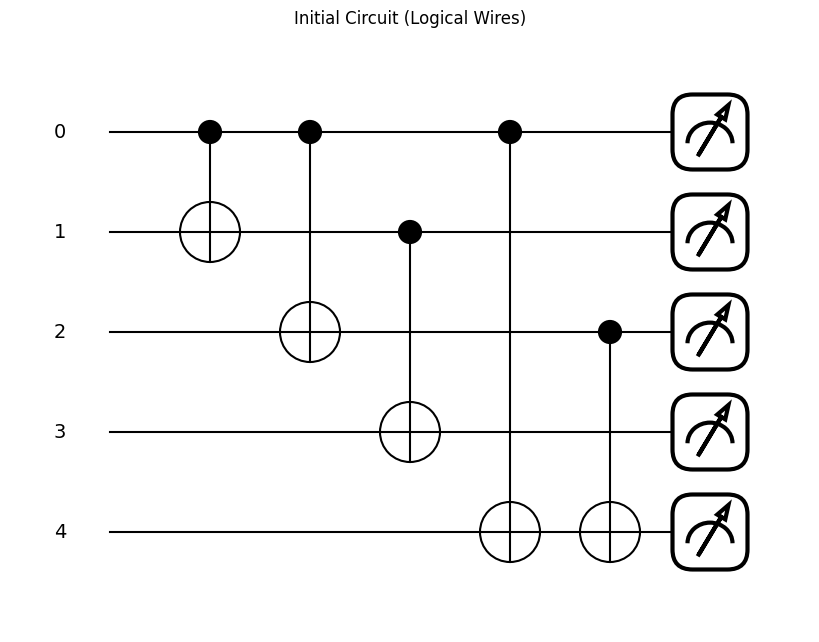

In [43]:
num_logical_qubits = count_logical_qubits(circuit)
dev_init = qml.device("default.qubit", wires=num_logical_qubits)

def create_initial_qnode(circuit):
    @qml.qnode(dev_init)
    def qnode():
        for (gate_type, qubits, gate_id) in circuit:
            if gate_type == "CNOT":
                ctrl, tgt = qubits
                qml.CNOT(wires=[ctrl, tgt])
            # If you had single-qubit gates, do similarly
        return qml.state()
    return qnode

init_qnode = create_initial_qnode(circuit)

fig, ax = qml.draw_mpl(init_qnode)()
plt.title("Initial Circuit (Logical Wires)")
plt.show()

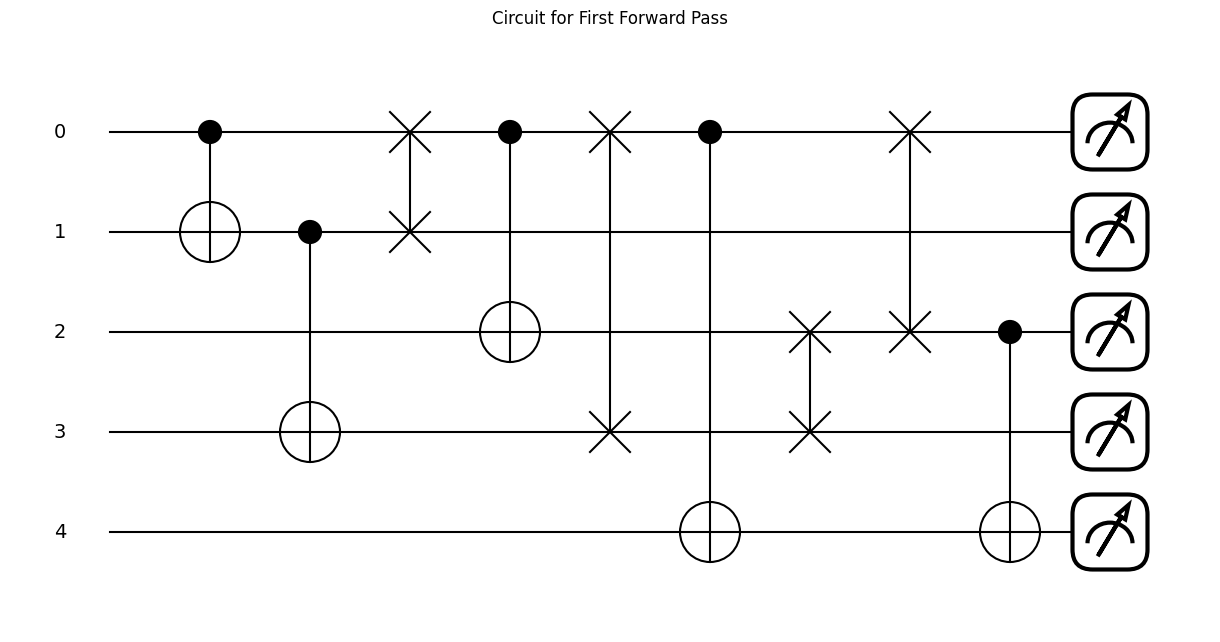

In [44]:
num_physical_qubits, sorted_physical_list = count_physical_qubits(device_graph)
dev_final = qml.device("default.qubit", wires=sorted_physical_list)

def create_final_qnode(final_circuit, original_circuit, sorted_phys):
    # build a dict: gate_id -> (type, [lq1, lq2])
    gate_dict = {g[2]:(g[0], g[1]) for g in original_circuit}

    @qml.qnode(dev_final)
    def qnode():
        for step in final_circuit:
            action, payload = step
            if action == "SWAP":
                (p_label, q_label,lqp,lqq) = payload
                # This is a logical-wire SWAP
                qml.SWAP(wires=[lqp, lqq])

            elif action == "EXECUTE":
                g_id = payload
                gtype, (lq1, lq2) = gate_dict[g_id]
                if gtype == "CNOT":
                    qml.CNOT(wires=[lq1, lq2])
                # etc. for other gates
            else:
                raise ValueError("Unknown action: ", action)

        return qml.state()

    return qnode

final_qnode = create_final_qnode(fp_circuit, circuit, sorted_physical_list)

fig, ax = qml.draw_mpl(final_qnode)()
plt.title("Circuit for First Forward Pass")
plt.show()

### STEP 2: create reverse circuit and reverse DAG for backward pass.

In [45]:
def reverse_circuit(circuit):
    """
    Return a 'reversed' version of the circuit list.
    For pure SWAP-based scheduling, we often just need the order reversed.
    We do not invert the direction of CNOT gates here. 
    """
    rev = list(circuit)  # copy
    rev.reverse()
    # You might want to rename gate_ids, e.g. "g1_rev", or reorder them 
    # to reflect new indexing. For now, we just keep them reversed in place.
    return rev

def build_reversed_dag(forward_dag):
    """
    Return a new DAG where each edge is reversed: 
    If forward_dag[u] contains v, then reversed_dag[v] contains u.
    """
    rev_dag = defaultdict(list)
    for u in forward_dag:
        for v in forward_dag[u]:
            rev_dag[v].append(u)
    return rev_dag

In [46]:
circuit = reverse_circuit(circuit)
circuit_dag = build_reversed_dag(circuit_dag)

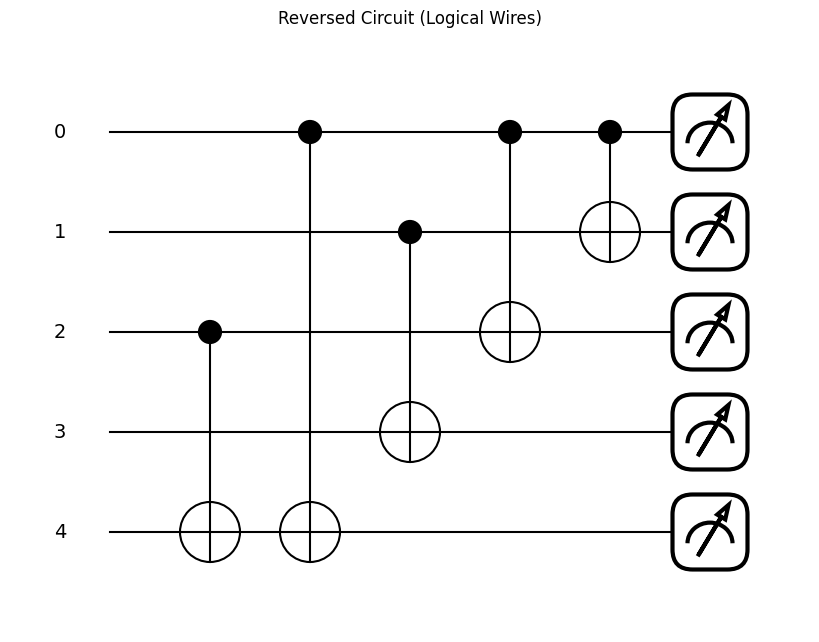

In [47]:
init_qnode = create_initial_qnode(circuit)

fig, ax = qml.draw_mpl(init_qnode)()
plt.title("Reversed Circuit (Logical Wires)")
plt.show()

### STEP 3: Rerun SABRE search for reverse circuit and reverse DAG. This time the input initial mapping is not random but it is the mapping result of the forward pass iteration

In [48]:
rev_circuit, rev_mapping = sabre_swap_search(
    circuit, circuit_dag, gate_list, fp_mapping, device_graph, dist_matrix
)

In [49]:
print("SABRE First Pass Mapping:", fp_mapping)
print("Reverse Pass Mapping:", rev_mapping)
print("Reverse Pass Circuit (SWAP + EXECUTE steps):")

for step in rev_circuit:
    if step[0] == "SWAP":
        print((step[0],(step[1][0],step[1][1])))
    else:
        print(step)

SABRE First Pass Mapping: {0: 1, 1: 0, 2: 3, 3: 2, 4: 4}
Reverse Pass Mapping: {0: 3, 1: 1, 2: 0, 3: 2, 4: 4}
Reverse Pass Circuit (SWAP + EXECUTE steps):
('EXECUTE', 'g5')
('SWAP', (1, 3))
('EXECUTE', 'g4')
('EXECUTE', 'g2')
('SWAP', (0, 1))
('EXECUTE', 'g3')
('EXECUTE', 'g1')


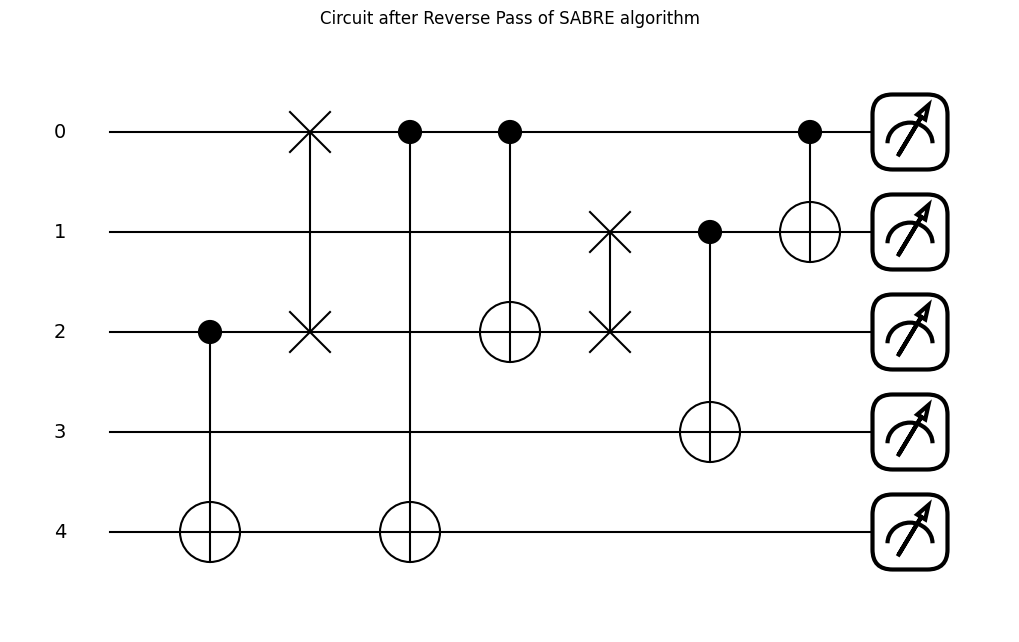

In [50]:

final_qnode = create_final_qnode(rev_circuit, circuit, sorted_physical_list)

fig, ax = qml.draw_mpl(final_qnode)()
plt.title("Circuit after Reverse Pass of SABRE algorithm")
plt.show()

### STEP 4: Again reverse the previous circuit and DAG to get original circuit and DAG for final forward pass.

In [51]:
circuit = reverse_circuit(circuit)
print(circuit)
circuit_dag = build_reversed_dag(circuit_dag)

[('CNOT', [0, 1], 'g1'), ('CNOT', [0, 2], 'g2'), ('CNOT', [1, 3], 'g3'), ('CNOT', [0, 4], 'g4'), ('CNOT', [2, 4], 'g5')]


### STEP 5: Final iteration of SABRE search using original circuit and DAG. The input mapping is the resultant mapping got from running the backward pass in previous step.

In [52]:
final_circuit, final_mapping = sabre_swap_search(
    circuit, circuit_dag,gate_list, rev_mapping, device_graph, dist_matrix
)

In [53]:

print("Reverse Pass Mapping:", rev_mapping)
print("Final Mapping:", final_mapping)
print("Final Circuit (SWAP + EXECUTE steps):")

for step in final_circuit:
    if step[0] == "SWAP":
        print((step[0],(step[1][0],step[1][1])))
    else:
        print(step)

Reverse Pass Mapping: {0: 3, 1: 1, 2: 0, 3: 2, 4: 4}
Final Mapping: {0: 1, 1: 0, 2: 3, 3: 2, 4: 4}
Final Circuit (SWAP + EXECUTE steps):
('EXECUTE', 'g1')
('EXECUTE', 'g3')
('SWAP', (0, 1))
('EXECUTE', 'g2')
('EXECUTE', 'g4')
('SWAP', (1, 3))
('EXECUTE', 'g5')


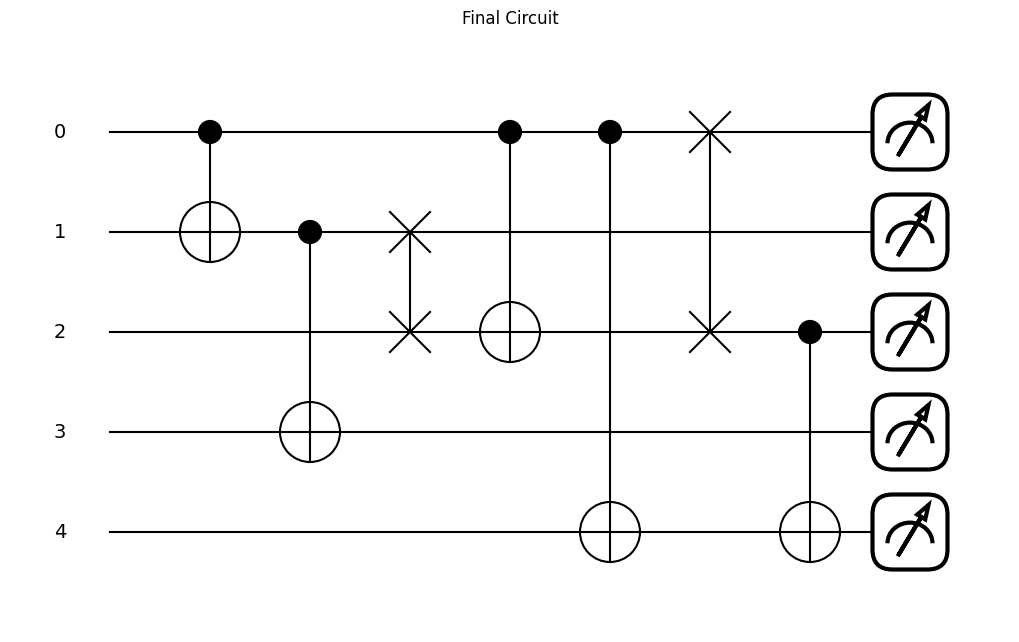

In [54]:
final_qnode = create_final_qnode(final_circuit, circuit, sorted_physical_list)

fig, ax = qml.draw_mpl(final_qnode)()
plt.title("Final Circuit")
plt.show()

## Questions and Issues:
#### 1. Why is the circuit result of manual solution and code not same? 
####    SABRE is using 1 SWAP more. Is it not deterministic or do we need to run the SABRE algorithm for multiple iterations?

### Future Work and Ideas:
- #### Instead of SWAPS we can use teleportation by distributing EPR pairs earlier and using when needed. This will result in 	a denser connected graph. But this density will decrease as the program runs because we need EPR pair between nodes which need to 	be physically distributed and each pair is a one time resource.
- #### Hypergraph representation of logical circuit where edges are sets of arbitrary number of qubits instead of pairs of qubits to accommodate higher order qubit interaction gates such as toffoli gates for future systems when hardware will be able to enable multi qubit interaction.
- ####  In device graph, we can have edge weights that can be used to account for variables such as error rate of different physical qubits, distance between different qubits and gate based error rate (eg. measurement errors in some qubits being high would mean that we should not use those qubits for measurements).
- #### Gate execution time is not being considered.
